In [ ]:
import pandas as pd
import numpy as np
import duckdb
import time

# Generate test data
rows = 10
cols = 10
df = pd.DataFrame({
    'A': [list(np.random.randint(0, 100, size=cols)) for _ in range(rows)],
    'B': [list(np.random.randint(0, 100, size=cols)) for _ in range(rows)],
})

print("Sample data:")
print(df.head())

Sample data:
                                          A  \
0   [57, 74, 70, 46, 88, 92, 4, 23, 25, 43]   
1  [96, 89, 67, 17, 23, 55, 72, 68, 94, 37]   
2   [80, 85, 70, 2, 11, 95, 34, 31, 38, 53]   
3    [5, 86, 73, 2, 70, 14, 85, 13, 62, 56]   
4   [50, 13, 26, 75, 85, 83, 20, 0, 54, 64]   

                                         B  
0  [57, 23, 34, 30, 7, 14, 46, 23, 94, 99]  
1  [28, 87, 52, 30, 1, 77, 73, 20, 37, 19]  
2  [7, 33, 46, 10, 29, 86, 71, 99, 38, 35]  
3  [36, 19, 0, 81, 34, 38, 33, 93, 19, 20]  
4  [13, 22, 70, 59, 2, 20, 79, 29, 93, 87]  


In [ ]:
# Connect to DuckDB and create proper table
con = duckdb.connect()

con.execute("DROP TABLE IF EXISTS matrix_table")
con.execute("""
    CREATE TABLE matrix_table (
        A DOUBLE[],  -- Use DOUBLE[] for variable-size arrays
        B DOUBLE[]   -- Use DOUBLE[] for variable-size arrays
    )
""")

# Insert the data row by row (convert numpy.int64 to float)
for _, row in df.iterrows():
    a_list = [float(x) for x in row['A']]  # Convert to float
    b_list = [float(x) for x in row['B']]  # Convert to float
    con.execute("INSERT INTO matrix_table VALUES (?, ?)", (a_list, b_list))

In [ ]:
# Benchmarking: Element-wise addition using DuckDB
start = time.time()

result = con.execute("""
    SELECT list_apply(list_zip(A, B), x -> x[1] + x[2]) AS result
    FROM matrix_table
""").fetchall()

end = time.time()

print(f"Element-wise addition inside DuckDB took {end - start:.6f} seconds")
print("Sample result (all rows):")
for row in result[:3]:
    print(row[0])

Element-wise addition inside DuckDB took 0.002045 seconds
Sample result (all rows):
[114.0, 97.0, 104.0, 76.0, 95.0, 106.0, 50.0, 46.0, 119.0, 142.0]
[124.0, 176.0, 119.0, 47.0, 24.0, 132.0, 145.0, 88.0, 131.0, 56.0]
[87.0, 118.0, 116.0, 12.0, 40.0, 181.0, 105.0, 130.0, 76.0, 88.0]


In [ ]:
# Benchmarking: Element-wise multiplication using DuckDB
start = time.time()

result = con.execute("""
    SELECT list_apply(list_zip(A, B), x -> x[1] * x[2]) AS result
    FROM matrix_table
""").fetchall()

end = time.time()

print(f"Element-wise multiplication inside DuckDB took {end - start:.6f} seconds")
print("Sample result (all rows):")
for row in result[:3]:
    print(row[0])

Element-wise multiplication inside DuckDB took 0.001976 seconds
Sample result (all rows):
[3249.0, 1702.0, 2380.0, 1380.0, 616.0, 1288.0, 184.0, 529.0, 2350.0, 4257.0]
[2688.0, 7743.0, 3484.0, 510.0, 23.0, 4235.0, 5256.0, 1360.0, 3478.0, 703.0]
[560.0, 2805.0, 3220.0, 20.0, 319.0, 8170.0, 2414.0, 3069.0, 1444.0, 1855.0]


In [ ]:
# Benchmarking: Dot product using DuckDB
start = time.time()

result = con.execute("""
    SELECT list_sum(list_apply(list_zip(A, B), x -> x[1] * x[2])) AS dot_product
    FROM matrix_table
""").fetchall()

end = time.time()

print(f"Dot product inside DuckDB took {end - start:.6f} seconds")
print("Sample result (all rows):")
for row in result[:3]:
    print(row[0])

Dot product inside DuckDB took 0.004117 seconds
Sample result (all rows):
17935.0
29480.0
23876.0


Matrix Multiplication Results (dot products):
Row 1: 17935.0
Row 2: 29480.0
Row 3: 23876.0
Row 4: 11200.0
Row 5: 21181.0
Row 6: 19737.0
Row 7: 29102.0
Row 8: 18238.0
Row 9: 23627.0
Row 10: 22500.0

Calculated Inner Product took 0.001387 seconds


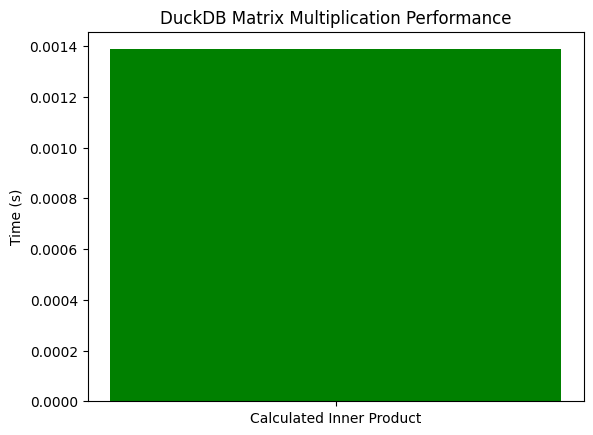

In [ ]:
import matplotlib.pyplot as plt
import time
import duckdb
import pandas as pd
import numpy as np

# Connect to DuckDB
con = duckdb.connect()

# Recreate the matrix_table and insert data
con.execute("DROP TABLE IF EXISTS matrix_table")
con.execute("""
    CREATE TABLE matrix_table (
        A DOUBLE[],  -- Use DOUBLE[] for variable-size arrays
        B DOUBLE[]   -- Use DOUBLE[] for variable-size arrays
    )
""")

# Insert data row-by-row if df is defined
if 'df' in locals():
    for _, row in df.iterrows():
        a_list = [float(x) for x in row['A']]  # Convert to float
        b_list = [float(x) for x in row['B']]  # Convert to float
        con.execute("INSERT INTO matrix_table VALUES (?, ?)", (a_list, b_list))
else:
    print("Error: DataFrame 'df' not found. Cannot recreate matrix_table.")

# -----------------------------
# Matrix Multiplication using list_sum and list_apply (equivalent to dot product)
# -----------------------------
start = time.time()
result = con.execute("""
    SELECT list_sum(list_apply(list_zip(A, B), x -> x[1] * x[2])) AS dot_product
    FROM matrix_table
""").fetchall()
end = time.time()

# Print result (optional)
print("Matrix Multiplication Results (dot products):")
for i, row in enumerate(result):
    print(f"Row {i + 1}: {row[0]}")

# -----------------------------
# Plotting performance
# -----------------------------
elapsed = end - start
print(f"\nCalculated Inner Product took {elapsed:.6f} seconds")
plt.bar(["Calculated Inner Product"], [elapsed], color='green')
plt.ylabel("Time (s)")
plt.title("DuckDB Matrix Multiplication Performance")
plt.show()

DuckDB SQL time: 0.001387 seconds
NumPy einsum time: 0.000247 seconds


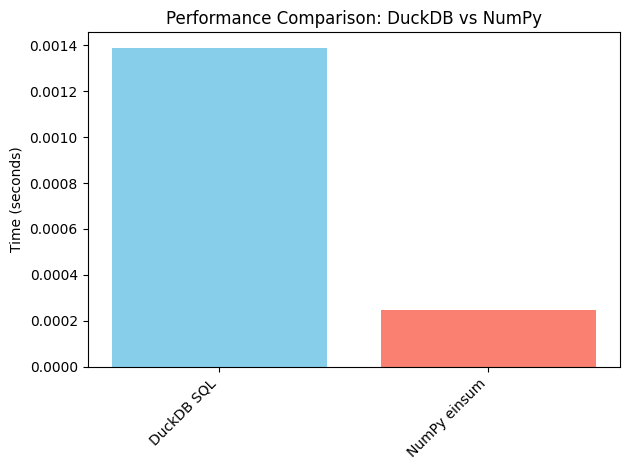


--- Result Comparison ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ---- Step 1: Recreate the same matrices (if not already available) ----
if 'df' in locals():
    A_matrix = [row['A'] for _, row in df.iterrows()]
    B_matrix = [row['B'] for _, row in df.iterrows()]
else:
    rows = 10
    cols = 10
    A_matrix = [np.random.randint(1, 10, size=cols).tolist() for _ in range(rows)]
    B_matrix = [np.random.randint(1, 10, size=cols).tolist() for _ in range(rows)]


# Convert to NumPy arrays for einsum
A_np = np.array(A_matrix)
B_np = np.array(B_matrix)

# ---- Step 2: DuckDB result (already available as `result` and `elapsed`) ----
# `result` is a list of dot products, no reshaping needed for comparison
duckdb_result_list = [row[0] for row in result] # Extract float values from tuples


# ---- Step 3: NumPy einsum multiplication ----
# Note: This calculates the matrix product of A and B transpose (10x10 matrix),
# which is different from the row-wise dot products calculated by DuckDB.
start_ein = time.time()
C_ein = np.einsum('ij,jk->ik', A_np, np.array(B_matrix).T) # Use B_matrix directly for transpose
end_ein = time.time()
ein_time = end_ein - start_ein

print(f"DuckDB SQL time: {elapsed:.6f} seconds")
print(f"NumPy einsum time: {ein_time:.6f} seconds")

# ---- Step 4: Visualize time comparison ----
plt.bar(['DuckDB SQL', 'NumPy einsum'], [elapsed, ein_time], color=['skyblue', 'salmon'])
plt.ylabel("Time (seconds)")
plt.title("Performance Comparison: DuckDB vs NumPy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---- Step 5: Check result similarity ----
# Cannot directly compare row-wise dot products with a full matrix product.
print("\n--- Result Comparison ---")


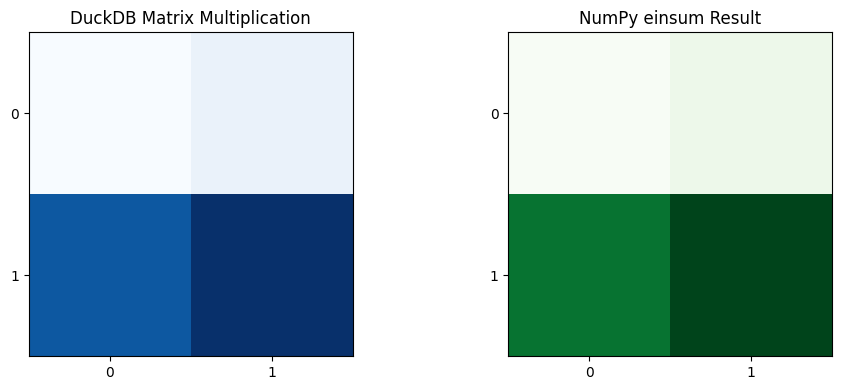

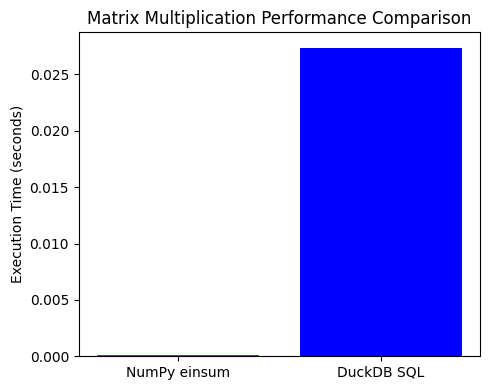

DuckDB Result:
 [[ 58.  64.]
 [139. 154.]]
NumPy Result:
 [[ 58  64]
 [139 154]]
Match: True
NumPy einsum time: 0.000154 seconds
DuckDB SQL time:  0.027362 seconds


In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Define matrices A and B (same as your einsum example)
A = np.array([[1, 2, 3],
              [4, 5, 6]])

B = np.array([[7, 8],
              [9, 10],
              [11, 12]])

# Convert to DataFrame with array columns
# df_A: row_id (0, 1), row (list of 3) - Represents rows of A
df_A = pd.DataFrame({'row_id': list(range(A.shape[0])), 'row': list(A)})
# df_B: row_id_b (0, 1, 2), row (list of 2) - Represents rows of B
df_B = pd.DataFrame({'row_id_b': list(range(B.shape[0])), 'row': list(B)})

# Create DuckDB connection and register tables
con = duckdb.connect()
con.register('a', df_A)
con.register('b', df_B)

# DuckDB full matrix multiplication using SQL (A (2x3) * B (3x2) -> C (2x2)) with timing
# C[i][j] = sum(A[i][k] * B[k][j])
start_duck = time.perf_counter()
result_df = con.execute("""
WITH a_unnest AS (
    SELECT
        row_id AS row_a_idx,
        i.generate_series - 1 AS col_a_idx, -- k index
        a.row[i.generate_series] AS a_val
    FROM a, generate_series(1, array_length(a.row)) AS i
),
b_unnest AS (
    SELECT
        row_id_b AS row_b_idx, -- k index
        i.generate_series - 1 AS col_b_idx, -- j index
        b.row[i.generate_series] AS b_val
    FROM b, generate_series(1, array_length(b.row)) AS i
)
SELECT
    a_unnest.row_a_idx AS row,    -- i index
    b_unnest.col_b_idx AS col,    -- j index
    SUM(a_unnest.a_val * b_unnest.b_val) AS value
FROM a_unnest
JOIN b_unnest
  ON a_unnest.col_a_idx = b_unnest.row_b_idx -- Join on inner dimension index (k)
GROUP BY a_unnest.row_a_idx, b_unnest.col_b_idx
ORDER BY row, col
""").fetchdf()
end_duck = time.perf_counter()

# Convert result to matrix
rows = result_df['row'].max() + 1
cols = result_df['col'].max() + 1
duckdb_result = np.zeros((rows, cols))
for _, r in result_df.iterrows():
    duckdb_result[int(r['row']), int(r['col'])] = r['value']

# NumPy einsum with timing
start_np = time.perf_counter()
numpy_result = np.einsum('ik,kj->ij', A, B)
end_np = time.perf_counter()

# Plot result matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(duckdb_result, cmap='Blues', interpolation='nearest')
axes[0].set_title('DuckDB Matrix Multiplication')
axes[0].set_xticks(range(cols))
axes[0].set_yticks(range(rows))

axes[1].imshow(numpy_result, cmap='Greens', interpolation='nearest')
axes[1].set_title('NumPy einsum Result')
axes[1].set_xticks(range(cols))
axes[1].set_yticks(range(rows))

plt.tight_layout()
plt.show()

# Plot performance comparison
time_duck = end_duck - start_duck
time_np = end_np - start_np

plt.figure(figsize=(5, 4))
plt.bar(['NumPy einsum', 'DuckDB SQL'], [time_np, time_duck], color=['green', 'blue'])
plt.ylabel("Execution Time (seconds)")
plt.title("Matrix Multiplication Performance Comparison")
plt.tight_layout()
plt.show()

# Print results
print("DuckDB Result:\n", duckdb_result)
print("NumPy Result:\n", numpy_result)
print("Match:", np.allclose(duckdb_result, numpy_result))
print(f"NumPy einsum time: {time_np:.6f} seconds")
print(f"DuckDB SQL time:  {time_duck:.6f} seconds")

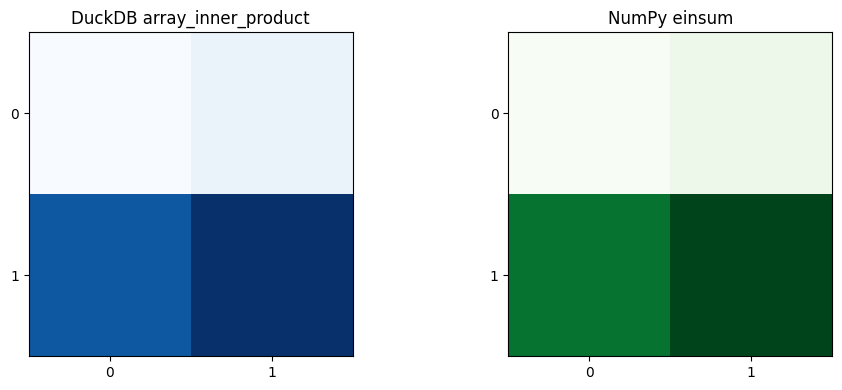

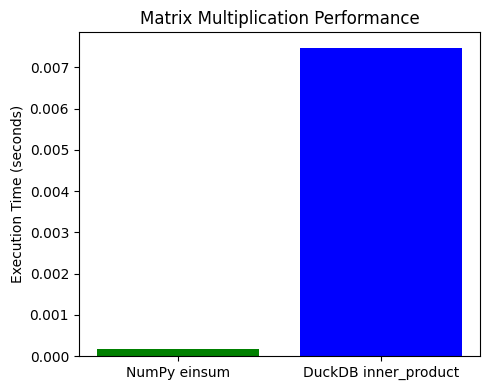

DuckDB result:
 [[ 58.  64.]
 [139. 154.]]
NumPy result:
 [[ 58.  64.]
 [139. 154.]]
Match: True
NumPy einsum time: 0.000174 seconds
DuckDB inner_product time:  0.007477 seconds


In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Input matrices
A = np.array([[1, 2, 3],
              [4, 5, 6]], dtype=np.float64)

B = np.array([[7, 8],
              [9, 10],
              [11, 12]], dtype=np.float64)

# Transpose B so its columns become rows
B_T = B.T  # Shape: (2x3)

# Connect and register with DuckDB
con = duckdb.connect()

# Create DuckDB tables with explicit ARRAY types
# For A, each row is a DOUBLE[3]
con.execute("CREATE TABLE a (row_id INTEGER, row DOUBLE[3])")
for i, row_data in enumerate(A.tolist()):
    con.execute(f"INSERT INTO a VALUES (?, ?)", (i, row_data))

# For B_T, each row is also a DOUBLE[3]
con.execute("CREATE TABLE bt (col_id INTEGER, row DOUBLE[3])")
for i, col_data in enumerate(B_T.tolist()):
    con.execute(f"INSERT INTO bt VALUES (?, ?)", (i, col_data))

# DuckDB matrix multiplication using array_inner_product directly
start_duck = time.perf_counter()
result_df = con.execute("""
SELECT
  a.row_id AS row,
  bt.col_id AS col,
  array_inner_product(a.row, bt.row) AS value
FROM a
CROSS JOIN bt
ORDER BY row, col
""").fetchdf()
end_duck = time.perf_counter()
time_duck = end_duck - start_duck

# Convert result to matrix
rows = result_df['row'].max() + 1
cols = result_df['col'].max() + 1
duckdb_result = np.zeros((rows, cols))
for _, r in result_df.iterrows():
    duckdb_result[int(r['row']), int(r['col'])] = r['value']

# NumPy einsum for comparison
start_np = time.perf_counter()
numpy_result = np.einsum('ik,kj->ij', A, B)
end_np = time.perf_counter()
time_np = end_np - start_np

# Plot result matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(duckdb_result, cmap='Blues', interpolation='nearest')
axes[0].set_title('DuckDB array_inner_product')
axes[0].set_xticks(range(cols))
axes[0].set_yticks(range(rows))

axes[1].imshow(numpy_result, cmap='Greens', interpolation='nearest')
axes[1].set_title('NumPy einsum')
axes[1].set_xticks(range(cols))
axes[1].set_yticks(range(rows))

plt.tight_layout()
plt.show()

# Plot timing comparison
plt.figure(figsize=(5, 4))
plt.bar(['NumPy einsum', 'DuckDB inner_product'], [time_np, time_duck], color=['green', 'blue'])
plt.ylabel("Execution Time (seconds)")
plt.title("Matrix Multiplication Performance")
plt.tight_layout()
plt.show()

# Print results
print("DuckDB result:\n", duckdb_result)
print("NumPy result:\n", numpy_result)
print("Match:", np.allclose(duckdb_result, numpy_result))
print(f"NumPy einsum time: {time_np:.6f} seconds")
print(f"DuckDB inner_product time:  {time_duck:.6f} seconds")